In [7]:
import sys
import pygmsh as pg
import dolfin as dl
import mshr as ms
import numpy as np
import matplotlib.pyplot as plt
from hmm.stokes_fenics import StokesMacProb, StokesData, MacroSol, MacroSolver, StokesMicProb, MicroSolver, StokesHMMProblem, macro_to_micro, micros_to_macro
from hmm.hmm import IterativeHMMSolver
from util.basis_scaled import FourBasis, ScaleShiftedBasis
from util.mesh_tools import Box, order_connected_vertices, boundary_bbox_tree, find_intersection_on_segment, plot_boundary_mesh
from util.random import smooth_random_loop_fourier_coef, fourierGP_2D_lerp
from util.logger import EventTracker
from util.plot_tools import remove_axes
from dataclasses import dataclass
import meshio
import gmsh
from typing import List, Tuple, Callable, Dict, Optional, Union

In [8]:
mesh_dir = "/home/emastr/deep-micro-slip-model/data/mesh/"

def list_sum(lists):
    return [item for sublist in lists for item in sublist]

def create_mesh(mesh, cell_type, prune_z=False):
    cells = mesh.get_cells_type(cell_type)
    cell_data = mesh.get_cell_data("gmsh:physical", cell_type)
    points = mesh.points[:,:2] if prune_z else mesh.points
    out_mesh = meshio.Mesh(points=points, cells={cell_type: cells}, cell_data={"name_to_read":[cell_data]})
    return out_mesh

class CircleDomain(dl.SubDomain):
    def __init__(self, x, y, r, tol, bdry=True):
        self.x = x
        self.y = y
        self.r = r
        self.tol = tol
        self.bdry = bdry
        super(CircleDomain, self).__init__()
        
    def inside(self, x, on_boundary):
        if self.bdry:
            return bool(dl.near((x[0]-self.x)**2 + (x[1]-self.y)**2, self.r**2, self.tol) and on_boundary)
        else:
            return bool(dl.near((x[0]-self.x)**2 + (x[1]-self.y)**2, self.r**2, self.tol))
        

class UnionDomain(dl.SubDomain):
    def __init__(self, domains):
        self.domains = domains
        super(UnionDomain, self).__init__()
    
    def inside(self, x, on_boundary):
        return bool(any([domain.inside(x, on_boundary) for domain in self.domains]))


def circle(x, y, r, N):
    return ms.Circle(dl.Point(x, y), r) #N


@dataclass
class RoughKullager:
    # Main parameters
    R: float
    r: float
    N_blobs: int
    
    # Child parameters
    r_blobs: float
    x_blobs: List[dl.Point]
    bbox: List[List[float]]

    # File names
    name: str = ""
    rough_name: str = ""
    
    @staticmethod
    def from_main_pars(R, r, N_blobs):
        pos_blob = (R + r) / 2
        r_blob = (R - r) / 5
        thetas = np.linspace(0, 2*np.pi, N_blobs+1)[:-1]
        radii = np.cos(N_blobs/2 * thetas) * ((R - r)*(0.3) - r_blob) + pos_blob
        x_blobs = [dl.Point(rad*np.cos(theta), rad*np.sin(theta)) for rad, theta in zip(radii, thetas)]
        return RoughKullager(R, r, N_blobs, r_blob, x_blobs, [[-R, R], [-R, R]])
    
    
    def get_micro_points(self, N_per_blob):
        pts = []
        for n in range(self.N_blobs):
            t = np.linspace(0, 2*np.pi, N_per_blob+1)[:-1]
            x = self.x_blobs[n].x()
            y = self.x_blobs[n].y()
            pts.append(np.hstack([x + self.r_blobs * np.cos(t)[:, None], y + self.r_blobs * np.sin(t)[:, None]]))
        return np.vstack(pts)
    
    
    def create_domains(self, TOL=0.03):
        outer = CircleDomain(0, 0, self.R, TOL, False)
        inner = CircleDomain(0, 0, self.r, TOL, False)
        inclusions = [CircleDomain(self.x_blobs[i].x(), self.x_blobs[i].y(), self.r_blobs, TOL, False) for i in range(self.N_blobs)]
        
        outer_bdry = CircleDomain(0, 0, self.R, TOL, True)
        inner_bdry = CircleDomain(0, 0, self.r, TOL, True)
        inclusion_boundaries = [CircleDomain(self.x_blobs[i].x(), self.x_blobs[i].y(), self.r_blobs, TOL, True) for i in range(self.N_blobs)]
        
        return outer, inner, inclusions, outer_bdry, inner_bdry, inclusion_boundaries
    
    
    def save_geometry(self, file_name, resmax, resmin):
        
        # Create the geometry
        with pg.geo.Geometry() as geom:
            outer = geom.add_circle([0, 0], self.R, mesh_size=resmin)
            inclusions = [geom.add_circle([0, 0], self.r, mesh_size=resmin)]
            for x_blob in self.x_blobs:
                inclusions.append(geom.add_circle([x_blob.x(), x_blob.y()], self.r_blobs, mesh_size=resmax))
            surf = geom.add_plane_surface(outer.curve_loop, holes=[inc.curve_loop for inc in inclusions])
            geom.add_physical(surf, label='Inside')
            geom.add_physical(outer.curve_loop.curves + inclusions[0].curve_loop.curves, label='Dirichlet')
            geom.add_physical(list_sum([inc.curve_loop.curves for inc in inclusions[1:]]), label='Roughness')
                        
            mesh = geom.generate_mesh(dim=2)
            gmsh.write(f'{mesh_dir}temp.msh')        
            
            mesh = meshio.read(f'{mesh_dir}temp.msh')
            
            bdry = create_mesh(mesh, "line", True)
            mesh = create_mesh(mesh, "triangle", True)
            
            meshio.write(f'{mesh_dir}{file_name}_volume.xdmf', mesh)
            meshio.write(f'{mesh_dir}{file_name}_boundary.xdmf', bdry)
        self.name = file_name
        
    
    def create_roughness(self, file_name, eps=0.004, lcar=0.002):
        # Create rough inset
        roughness_field, x, y = fourierGP_2D_lerp(kmax_x=1001, kmax_y=1001, L=0.04, LAmp=0., eps=0.004, epsAmp=0.02, dom=self.bbox)
        roughnesses = []
        N_ = 500
        for n in range(2 * self.N_blobs):
            n = n % self.N_blobs
            t = np.linspace(0, 2*np.pi, N_+1)[:-1]
            x = self.x_blobs[n].x()
            y = self.x_blobs[n].y()
            
            cos_t = np.cos(t)
            sin_t = np.sin(t)
            x_t = x + self.r_blobs * cos_t
            y_t = y + self.r_blobs * sin_t
            #r = self.r * 0.90# -roughness_field(x, y) #0.02*(1 + np.sin(100 * t)))#
            r = self.r_blobs - roughness_field(x_t, y_t) #0.02*(1 + np.sin(100 * t)))#
            roughnesses.append(np.hstack([x + (r * cos_t)[:, None], y + (r * sin_t)[:, None]]))
            
        with pg.geo.Geometry() as geom:
            #
            loops = []
            for n in range(2 * self.N_blobs):
                n = n % self.N_blobs
                roughness = roughnesses[n]
                points = []
                for x in roughness:
                    points.append(geom.add_point([x[0], x[1]], lcar))
                s1 = geom.add_bspline(points[0:N_//2+1])
                s2 = geom.add_bspline(points[N_//2:] + [points[0]])
                l  = geom.add_curve_loop([s1, s2])
                loops.append(l)
            geom.add_physical(loops, label='Roughness')
            mesh = geom.generate_mesh(dim=1)
            gmsh.write(f'{mesh_dir}temp.msh')        
            
            mesh = meshio.read(f'{mesh_dir}temp.msh')
            mesh = create_mesh(mesh, "line", True)
            meshio.write(f'{mesh_dir}{file_name}_roughness.xdmf', mesh)
        self.rough_name = file_name
    
    
    def load_meshes(self):
        file = dl.XDMFFile(f'{mesh_dir}{self.name}_volume.xdmf')
        mesh = dl.Mesh()
        file.read(mesh)

        bdry_file = dl.XDMFFile(f'{mesh_dir}{self.name}_boundary.xdmf')
        bdry = dl.Mesh()
        bdry_file.read(bdry)

        rough_file = dl.XDMFFile(f'{mesh_dir}{self.rough_name}_roughness.xdmf')
        bdry_rough = dl.Mesh()
        rough_file.read(bdry_rough)
        
        
        return mesh, bdry, bdry_rough
        

In [9]:
R = 1.
r = 0.3
N_blobs = 7

data = RoughKullager.from_main_pars(R, r, N_blobs)
#### ROUGHNESS FUNCTION ####
data.save_geometry('test_mesh', 0.02, 0.05) #0.03
data.create_roughness('test_mesh_2', 0.004, 0.001)
mesh, bdry, bdry_rough = data.load_meshes()
outer, inner, inclusions, outer_bdry, inner_bdry, inclusion_boundaries = data.create_domains(TOL=0.03)


plt.figure(figsize=(10, 10))
dl.plot(mesh)
plot_boundary_mesh(bdry_rough, color='r')

Exception: Unable to open file '/home/emastr/deep-micdo-slip-model/data/mesh/temp.msh'

Notation dx[meshfunction] is deprecated. Please use dx(subdomain_data=meshfunction) instead.
Building point search tree to accelerate distance queries.
Computed bounding box tree with 629 nodes for 315 points.
0.3483149703115894 0.32004406490907283
dom:   [0.         0.25       0.25153621 0.4988     0.5        0.75
 0.7512     0.99832809 1.        ]
diff:   [0.25       0.00153621 0.24726379 0.0012     0.25       0.0012
 0.24712809 0.00167191]
0.26254834365350493 0.2211652283975751heck if the intersection is on the segment, it just clips it.
dom:   [0.         0.25       0.25106159 0.4988     0.5        0.75
 0.7512     0.99873977 1.        ]
diff:   [0.25       0.00106159 0.24773841 0.0012     0.25       0.0012
 0.24753977 0.00126023]
0.32058154818217593 0.24190694520544262eck if the intersection is on the segment, it just clips it.
dom:   [0.         0.25       0.25116115 0.4988     0.5        0.75
 0.7512     0.99846121 1.        ]
diff:   [0.25       0.00116115 0.24763885 0.0012    

ValueError: No intersection found, pick a better box

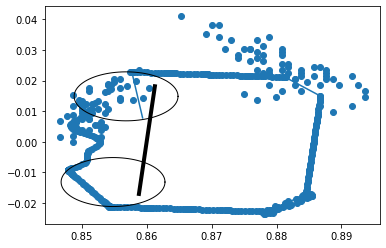

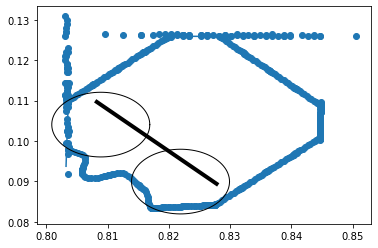

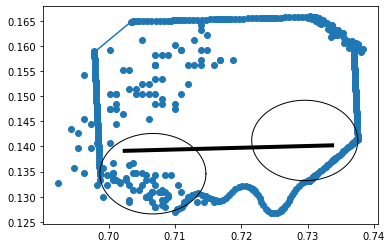

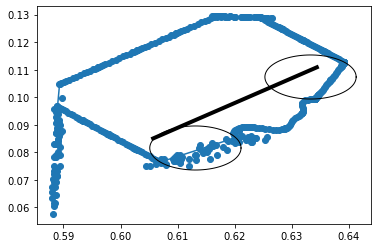

<Figure size 432x288 with 0 Axes>

In [ ]:
# Define the function spaces
P2 = dl.VectorElement(family='P', cell=dl.triangle, degree=2)
P1 = dl.FiniteElement(family='P', cell=dl.triangle, degree=1)
P2P1 = P2 * P1
W = dl.FunctionSpace(mesh, P2P1)
U, P = W.split() 
Ux, Uy = U.split()

# Boundary Conditions
bcu_inner = dl.DirichletBC(U, dl.Expression((f'x[1]/{r}', f'-x[0]/{r}'), degree=2), inner_bdry)
bcu_outer = dl.DirichletBC(U, dl.Expression((f'x[1]/{R}', f'-x[0]/{R}'), degree=2), outer_bdry)
bcu_inclusions = [dl.DirichletBC(U, dl.Constant((0., 0.)), inclusion) for inclusion in inclusion_boundaries]

stokes_data = StokesData.from_mesh(mesh, UnionDomain(inclusions), bdry_rough, W, [bcu_inner, bcu_outer])

alpha_means = []
def interp(x, a):
    amean = -np.mean(a)
    alpha_means.append(amean)
    print(amean)
    #return lambda x, y: amean #basis(np.array([x]))[0]
    return micros_to_macro(x, [-s for s in a], scale=1.0)
    #return lambda x,y: amean#: basis(np.array([x]))[0]

mac = StokesMacProb(stokes_data, interp=interp, alpha0=lambda x,y: 0.01, lam=1e3)
mac_solver = MacroSolver()
projection_op = lambda *args: macro_to_micro(*args, N=7)
pts = data.get_micro_points(8)
micros = []
for pt in pts:
    mic = StokesMicProb(stokes_data, pt, projection_op=projection_op, debug=False, width=0.02, height=0.02, corner_w=0.008, pad=0.03, n_refine=2)
    micros.append(mic)
hmm_prob = StokesHMMProblem(mac, micros, data)

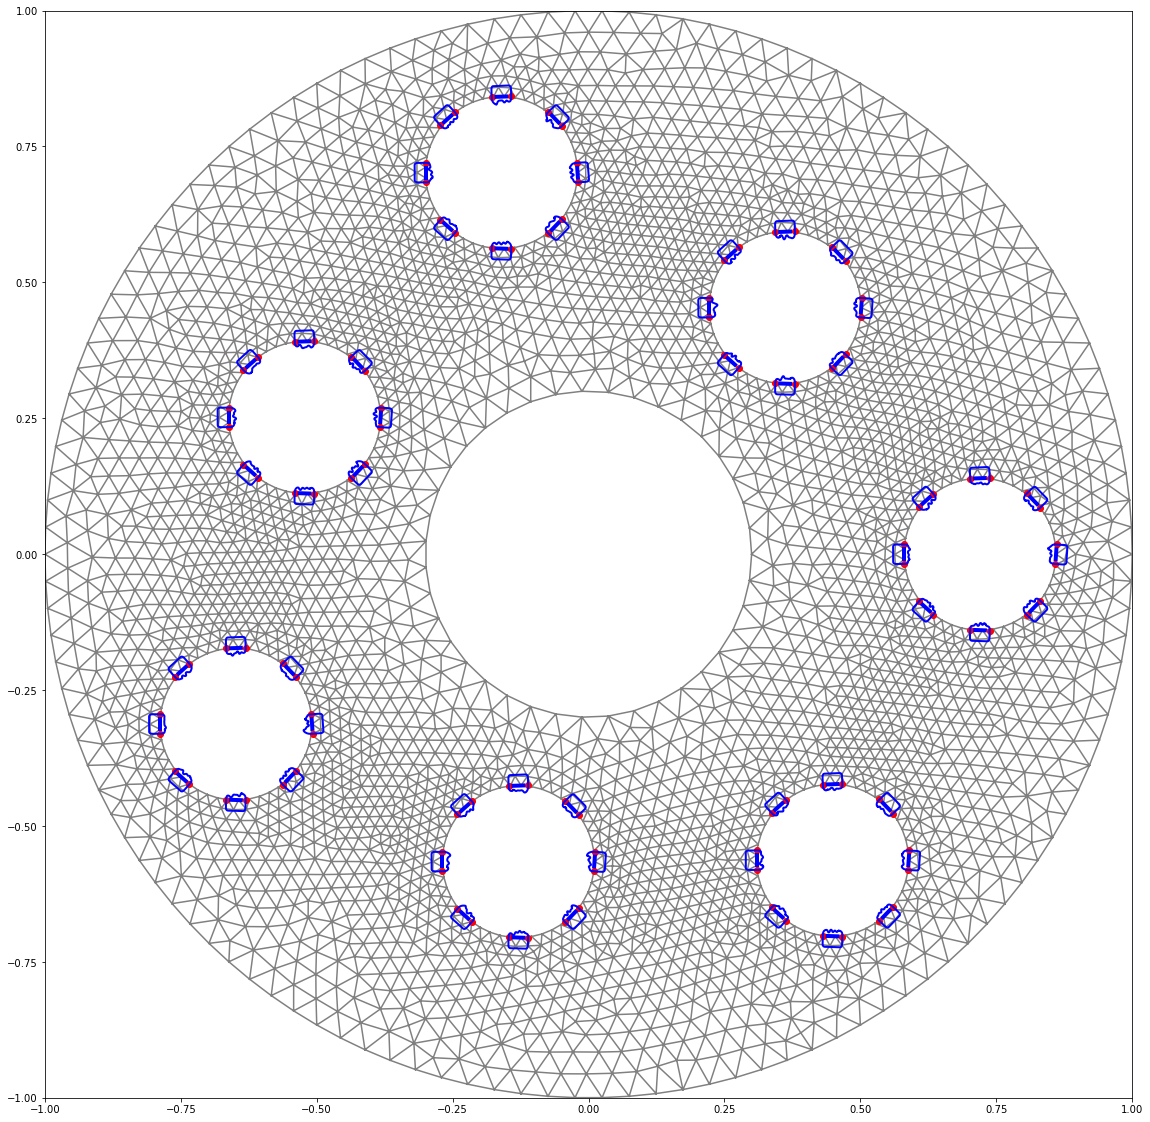

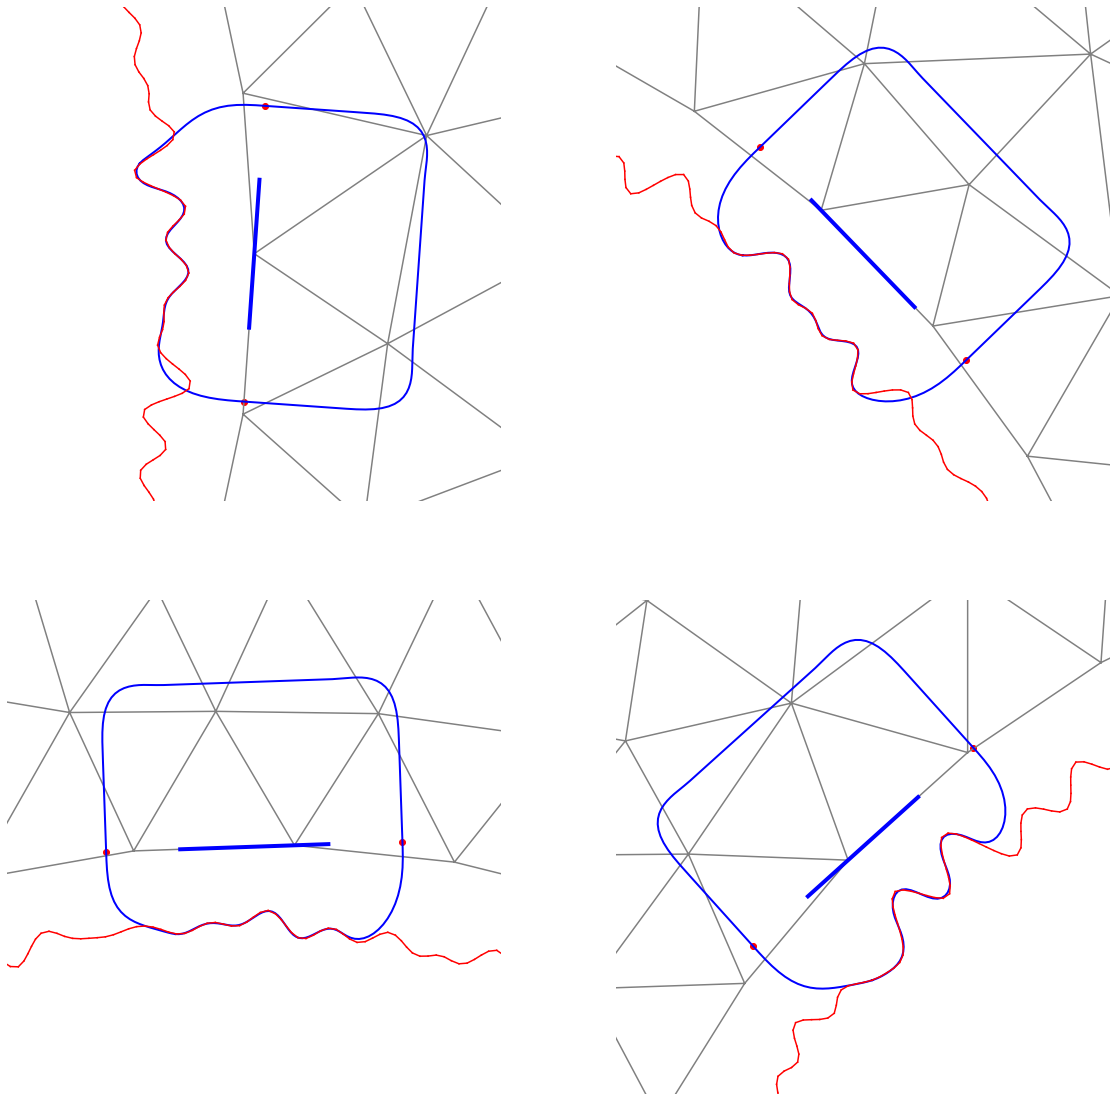

In [ ]:
plt.figure(figsize=(20,20))
stokes_data.plot(plt.gca())
#hmm_prob.plot(plt.gca(), color='black')
for mic in micros:
    mic.plot(plt.gca(), color='blue', linewidth=2)
plt.xlim(*data.bbox[0])
plt.ylim(*data.bbox[1])

plt.figure(figsize=(20,20))
n = 2#int(np.floor(np.sqrt(len(mics))))
for i in range(n*n):
    mic = micros[i]
    plt.subplot(n, n, i+1)
    mic.plot(plt.gca(), color='blue', linewidth=2)
    dl.plot(mesh)
    plot_boundary_mesh(bdry_rough, color='r')
    #pt.plot(roughness[:,0], roughness[:,1], 'r')
    remove_axes(plt.gca())
    plt.xlim([mic.center[0] - 3*mic.width/2, mic.center[0] + 3*mic.width/2])
    plt.ylim([mic.center[1] - 3*mic.width/2, mic.center[1] + 3*mic.width/2])
    

In [ ]:
logger = EventTracker()

logger.start_event("Precompute Micros")
mic_solvers = [MicroSolver(mic , tol=1e-6) for mic in micros]
logger.end_event("Precompute Micros")

hmm_solver = IterativeHMMSolver(mac_solver, mic_solvers)
guess = mac_solver.solve(mac, verbose=True)
macro_sol, micro_sols = hmm_solver.solve(hmm_prob, macro_guess=guess, maxiter=20, verbose=True, logger =logger)

plt.plot(alpha_means)

Solving linear variational problem.
Building point search tree to accelerate distance queries.
Computed bounding box tree with 13995 nodes for 6998 points.
0.007443605521712921ver, removing - sign
Solving linear variational problem.
0.007443605521712921
0.006718468018052515ver, removing - sign
Solving linear variational problem.
0.006718468018052515


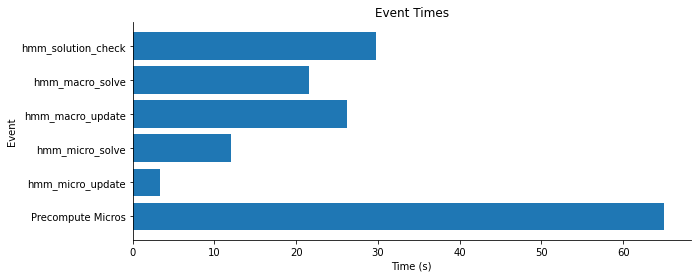

In [ ]:
plt.figure(figsize=(10,4))
logger.barplot_logs(plt.gca())

Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.


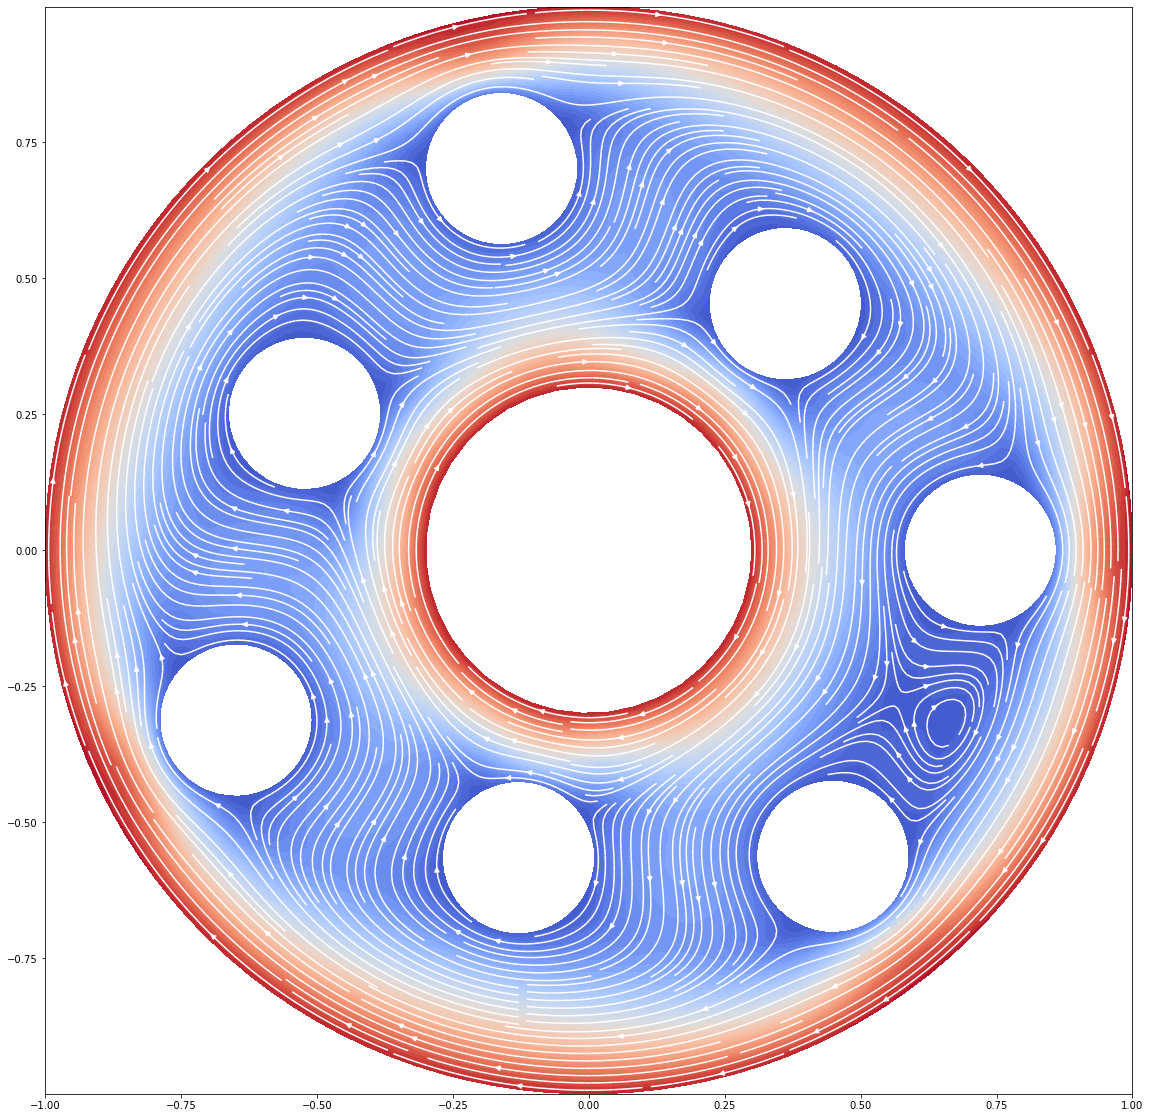

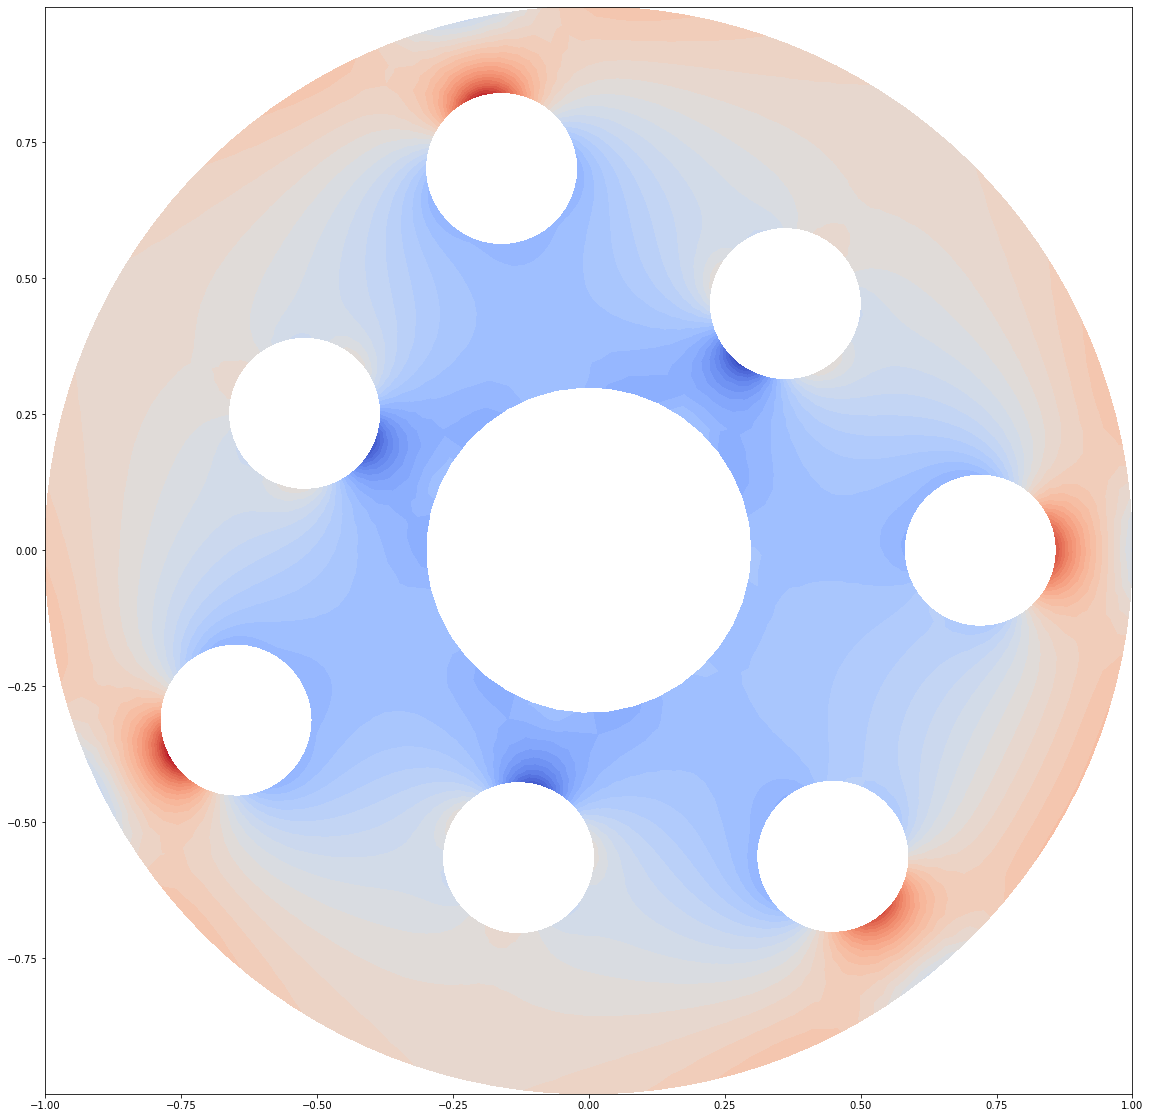

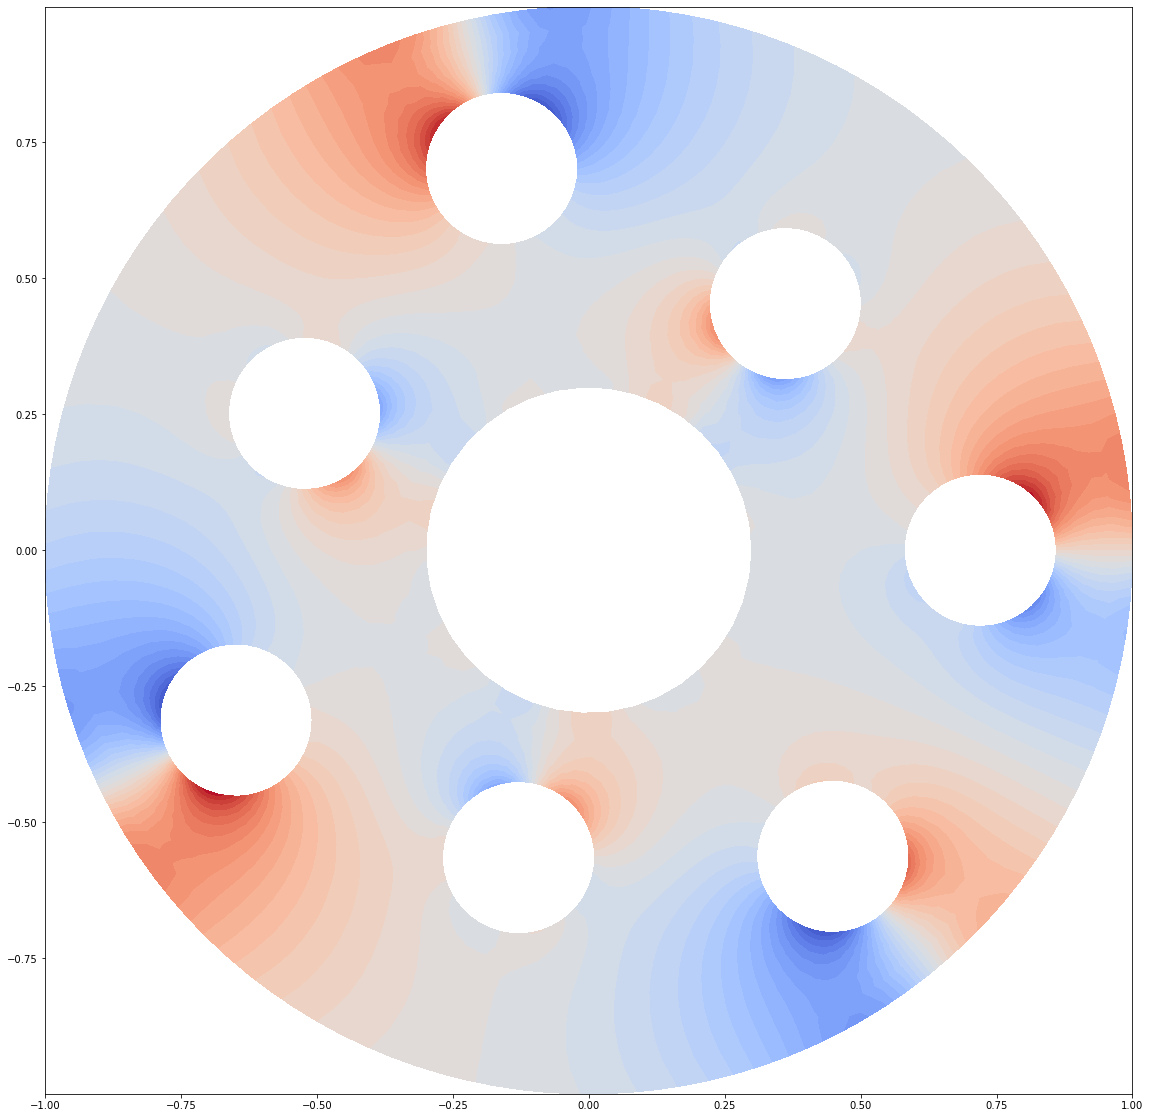

In [ ]:
#sol.u.vector()[:] = np.where(np.isnan(sol.u.vector()[:]), 0, sol.u.vector()[:])
#sol.v.vector()[:] = np.where(np.isnan(sol.v.vector()[:]), 0, sol.v.vector()[:])
sol = macro_sol
abs_u = (sol.u * sol.u + sol.v * sol.v) ** 0.5
w = sol.grad_u[1] - sol.grad_v[0]
#print(sol.u.vector()[:])

plt.figure(figsize=(20,20))
dl.plot(abs_u, cmap='coolwarm')#, vmin=0., vmax=1.)
sol.plot_stream(plt.gca(), dom=mesh, bbox=[[-1.,1.], [-1., 1.]], npts=300, color='white', density=5)

plt.figure(figsize=(20,20))
dl.plot(w, cmap='coolwarm')#, vmin=-10., vmax=10.)

plt.figure(figsize=(20,20))
dl.plot(sol.p, cmap='coolwarm')#, vmin=-20., vmax=20.)

0.006477413709366059


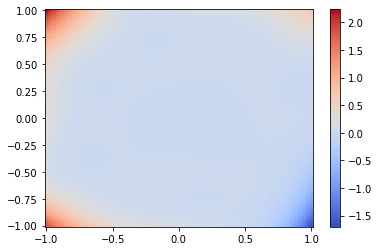

In [ ]:
interp_xa = interp([mic.x for mic in micro_sols], [mic.alpha for mic in micro_sols])

x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(x, y)
a = np.array([interp_xa(x, y) for x, y in zip(X.flatten(), Y.flatten())]).reshape(X.shape)
plt.pcolormesh(X, Y, a, cmap='coolwarm')
plt.colorbar()